In [20]:
# general
import warnings
from tqdm import tqdm
from datasets import load_dataset, Dataset
import time
from collections import defaultdict
from transforms.PermuteImage import PermuteImage
from os.path import isfile

# ML
import numpy as np
import pandas as pd

# visual
import matplotlib.pyplot as plt
import seaborn as sns

# # DL
import torch
import cv2
from torch import nn, Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms, models
from modules.HeadlessPretrainedModule import HeadlessPretrainedModule
from modules.CustomModule import CustomModule
from modules.CustomModule import CustomModule2
from transforms.Transform_Builder import Transform_Builder

warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
torch.cuda.empty_cache()

In [3]:
SEED = 42

## Load the dataset

In [4]:
dataset = load_dataset("cats_vs_dogs", trust_remote_code=True, verification_mode='no_checks')
dataset = dataset['train']

In [103]:
pretrain_transform = transforms.Compose([
    transforms.Resize((224, 224)),
   # PermuteImage(num_tiles=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

custom_transform = transforms.Compose([
    transforms.Resize((100, 100)),
   # PermuteImage(num_tiles=4),
    transforms.ToTensor(),
    transforms.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_transform =  custom_transform

def convert_to_rgb(img):
  if img.mode != 'RGB':
    img = img.convert('RGB')
  return img

def transform(examples):
   lst = []
   if examples.get('image'):
    for img in examples['image']:
      img = convert_to_rgb(img)
      lst.append(img_transform(img))
    examples['image'] = lst
    examples['labels'] = torch.tensor(examples['labels'], dtype=torch.int64)
   return examples 


In [ ]:
# indices = list(range(len(dataset)))
# split = int(np.floor(0.95 * len(dataset)))
# train_indices, test_indices = indices[:split], indices[split:]

# train_sampler = SubsetRandomSampler(train_indices)
# test_sampler = SubsetRandomSampler(test_indices)

In [ ]:
# np.random.seed(shuffle=True)
# dataloaders = {
#     'train': DataLoader(dataset, batch_size=32, sampler=train_sampler, drop_last=True, shuffle=True),
#     'val': DataLoader(dataset, batch_size=32, sampler=test_sampler, drop_last=True)
# }

In [5]:
splitted_dataset = dataset.train_test_split(test_size=0.05, shuffle=True, seed=SEED)
train_val_dataset = splitted_dataset['train'].train_test_split(test_size=0.05, shuffle=True, seed=SEED)

In [6]:
train = train_val_dataset['train']
val = train_val_dataset['test']
test = splitted_dataset['test']

In [7]:
def transform_datasets(datasets: tuple[Dataset], transform = callable):
    return (dataset.with_transform(transform) for dataset in datasets)

In [ ]:
dataiter = iter(dataloaders['test'])
next(dataiter)["image"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


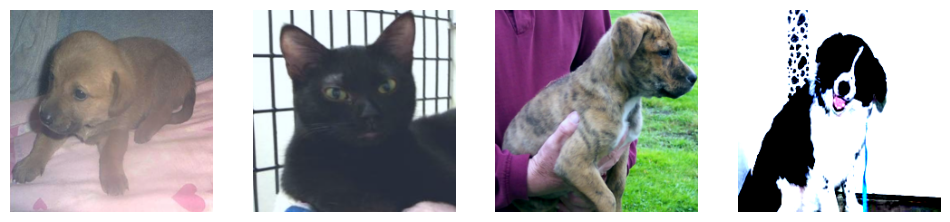

In [38]:
def denormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Get a batch of training data
iter = next(dataiter)
images, labels = iter['image'].clone(), iter['labels']

# Denormalize images for visualization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
images = denormalize(images, mean, std)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = images[i]
    img = np.transpose(img.numpy(), (1, 2, 0))  # Transpose to (H, W, C)
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

#### 1. Pretrained model baseline

In [8]:
pretrained_transform = Transform_Builder.build(size=224)
train_set, val_set, test_set = transform_datasets((train, val, test), transform=pretrained_transform)

In [9]:
dataloaders = {
    'train': DataLoader(train_set, batch_size=32, drop_last=True, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=32, drop_last=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=32, drop_last=True, num_workers=0),
}

In [10]:
pretrained_model = HeadlessPretrainedModule(pretrained_model = models.resnet50(pretrained=True), device=device)
pretrained_model = pretrained_model.to(device)

In [11]:
if isfile("./pretrained_model.pth"):
    pretrained_model.load_state_dict(torch.load("./pretrained_model.pth"))
else:
    lr = 5e-3
    num_epochs = 5

    optimizer = torch.optim.SGD(pretrained_model.parameters(), lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    pretrained_model.start_train(criterion, optimizer, dataloaders)
    torch.save(pretrained_model.state_dict(), "./pretrained_model.pth")

In [19]:
matches = pretrained_model.predict_data(dataloaders['test'])

Test Acc: 0.986979


##### 1.2 Evaluating premuted images

In [26]:
num_tiles_options = [4,9,16]

In [27]:
results = {"Tiles": [], "Accuracy": []}
for num_tiles in num_tiles_options:
    pretrained_transform_with_premute = Transform_Builder.build(size=224, with_premute=True, num_tiles=num_tiles)
    premuted_train_set, premuted_val_set, premuted_test_set = transform_datasets((train, val, test), transform=pretrained_transform_with_premute)
    premuted_dataloaders = {
        'train': DataLoader(premuted_train_set, batch_size=32, drop_last=True, shuffle=True, num_workers=0),
        'val': DataLoader(premuted_val_set, batch_size=32, drop_last=True, num_workers=0),
        'test': DataLoader(premuted_test_set, batch_size=32, drop_last=True, num_workers=0),
    }
    matches = pretrained_model.predict_data(premuted_dataloaders['test'])
    results["Tiles"].append(num_tiles)
    results["Accuracy"].append(pretrained_model.test_acc)

Test Acc: 0.957465
Test Acc: 0.911458
Test Acc: 0.875000


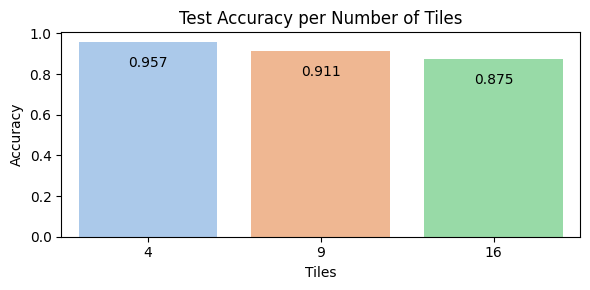

In [76]:
fig, ax = plt.subplots(figsize=(6,3))
g = sns.barplot(data = pd.DataFrame(results), y='Accuracy', x='Tiles', palette='pastel',  legend=False, ax=ax)
for i in g.containers:
    g.bar_label(i, padding=-20, fmt='%.3f')
plt.title('Test Accuracy per Number of Tiles');
plt.tight_layout()
plt.show()

In [200]:
matches = pretrained_model.predict_data(premuted_dataloaders['test'])

Test Acc: 0.951389


#### Custom model baseline

In [9]:
custom_model = CustomModule2(device=device)
custom_model = custom_model.to(device)

In [10]:
lr = 1e-3
num_epochs = 30

optimizer = torch.optim.Adam(custom_model.parameters(), lr)
criterion = nn.CrossEntropyLoss()

In [11]:
best_model = custom_model.start_train(criterion, optimizer, dataloaders, num_epochs=num_epochs)

Epoch 1/30
----------
train Loss: 0.0166  |  Acc: 0.7321
val Loss: 0.0170  |  Acc: 0.7371
Epoch 2/30
----------
train Loss: 0.0124  |  Acc: 0.8196
val Loss: 0.0123  |  Acc: 0.8116
Epoch 3/30
----------
train Loss: 0.0105  |  Acc: 0.8512
val Loss: 0.0124  |  Acc: 0.8208
Epoch 4/30
----------
train Loss: 0.0089  |  Acc: 0.8786
val Loss: 0.0146  |  Acc: 0.7849
Epoch 5/30
----------
train Loss: 0.0079  |  Acc: 0.8923
val Loss: 0.0090  |  Acc: 0.8833
Epoch 6/30
----------
train Loss: 0.0070  |  Acc: 0.9061
val Loss: 0.0094  |  Acc: 0.8732
Epoch 7/30
----------
train Loss: 0.0063  |  Acc: 0.9176
val Loss: 0.0128  |  Acc: 0.8309
Epoch 8/30
----------
train Loss: 0.0058  |  Acc: 0.9232
val Loss: 0.0201  |  Acc: 0.7840
Epoch 9/30
----------
train Loss: 0.0053  |  Acc: 0.9290
val Loss: 0.0086  |  Acc: 0.8879
Epoch 10/30
----------
train Loss: 0.0046  |  Acc: 0.9403
val Loss: 0.0081  |  Acc: 0.8925
Epoch 11/30
----------
train Loss: 0.0041  |  Acc: 0.9463
val Loss: 0.0098  |  Acc: 0.8998
Epoch 12

In [14]:
torch.save(custom_model.state_dict(), "./CustomModel.pth")

In [47]:
custom_model = CustomModule2(device=device)
custom_model.load_state_dict(torch.load("./CustomModel.pth"))
custom_model = custom_model.to(device)

In [48]:
match = custom_model.predict_data(dataloaders['test'])

Test Acc: 0.921007


In [53]:
test_images = splitted_dataset['test']['image']
tp_test_images = [test_images[i] for i in torch.argwhere(match)]

In [171]:
test_labels = splitted_dataset['test']['labels']
tp_test_labels = [test_labels[i] for i in torch.argwhere(match)]


In [185]:
from datasets import Dataset

dataset2 = Dataset.from_dict({'image': test_images, 'labels': test_labels})

In [62]:
img_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    PermuteImage(num_tiles=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def transform(examples):
  if examples.get('image'):
    examples['image'] = [img_transform(img.convert('RGB')) if img.mode != 'RGB' else img_transform(img) for img in examples['image']]
  return examples

In [338]:
img_transform.transforms.insert(0, PermuteImage(num_tiles=4))

In [337]:
img_transform

Compose(
    Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [91]:
import cv2 

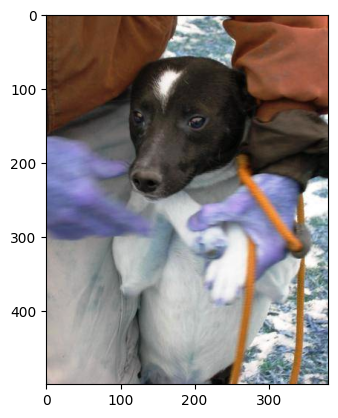

In [175]:
img = cv2.imread("./test/1.jpg")
plt.imshow(img)

In [178]:
d= permute_image(img, num_tiles=9)

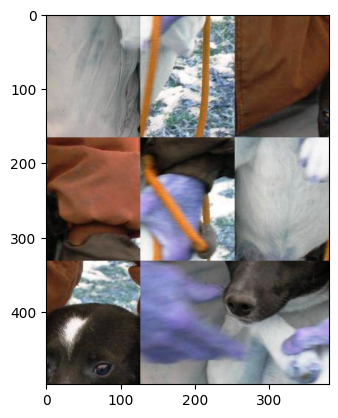

In [179]:
plt.imshow(d)

In [34]:
from transformers import ViTImageProcessor, ViTForImageClassification

In [35]:
model_name_or_path = 'nateraw/vit-base-cats-vs-dogs'

In [36]:
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

In [24]:
labels = dataset.features['labels'].names

In [25]:
pretrained_model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/675 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [257]:
model2 = ViTForImageClassification.from_pretrained(
    model_name_or_path
)

In [212]:
pretrained_model = pretrained_model.to(device)

In [360]:
f = processor(images_dataset['train'][0:3]['image'], return_tensors='pt')

In [362]:
f['pixel_values']

tensor([[[[ 0.5922,  0.6078,  0.6314,  ...,  0.9137,  0.8902,  0.8745],
          [ 0.5922,  0.6078,  0.6314,  ...,  0.9059,  0.8902,  0.8824],
          [ 0.5922,  0.6078,  0.6314,  ...,  0.9059,  0.8980,  0.8824],
          ...,
          [ 0.2078,  0.2157,  0.2235,  ..., -0.9765, -0.9765, -0.9765],
          [ 0.2000,  0.2000,  0.2078,  ..., -0.9843, -0.9843, -0.9843],
          [ 0.1843,  0.1922,  0.2000,  ..., -0.9922, -0.9922, -0.9922]],

         [[ 0.2863,  0.3020,  0.3255,  ...,  0.5922,  0.5843,  0.5686],
          [ 0.2863,  0.3020,  0.3255,  ...,  0.6078,  0.5843,  0.5765],
          [ 0.2863,  0.3020,  0.3255,  ...,  0.6078,  0.5922,  0.5765],
          ...,
          [-0.0353, -0.0275, -0.0196,  ..., -0.9765, -0.9765, -0.9765],
          [-0.0431, -0.0431, -0.0353,  ..., -0.9843, -0.9843, -0.9843],
          [-0.0588, -0.0510, -0.0431,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.3176, -0.3020, -0.2784,  ..., -0.0510, -0.0431, -0.0510],
          [-0.3176, -0.3020, -

In [264]:
type(f)

dict

In [113]:
def vit_transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [240]:
def vit_transform2(example_batch):
    # Take a list of PIL images and turn them to pixel values
    example_batch['image'] = processor(example_batch['image'], return_tensors='pt')['pixel_values']

    # Don't forget to include the labels!
    example_batch['labels'] = torch.tensor(example_batch['labels'], dtype=torch.int64) 
    return example_batch

In [148]:
img1 = splitted_dataset['test'][0]

In [233]:
processor(img1['image'], return_tensors='pt')

{'pixel_values': tensor([[[[ 0.3725,  0.3725,  0.3725,  ..., -0.2157, -0.2235, -0.2157],
          [ 0.3882,  0.3882,  0.3882,  ..., -0.2078, -0.2235, -0.2235],
          [ 0.3882,  0.3882,  0.3882,  ..., -0.2157, -0.2157, -0.2157],
          ...,
          [ 0.5137,  0.5373,  0.5843,  ...,  0.4980,  0.5216,  0.5373],
          [ 0.4667,  0.5216,  0.5608,  ...,  0.4824,  0.5059,  0.5373],
          [ 0.4196,  0.6078,  0.6078,  ...,  0.6314,  0.6471,  0.6157]],

         [[ 0.3255,  0.3255,  0.3255,  ..., -0.3882, -0.3961, -0.3882],
          [ 0.3412,  0.3412,  0.3412,  ..., -0.3804, -0.3961, -0.3961],
          [ 0.3412,  0.3412,  0.3412,  ..., -0.3882, -0.3882, -0.3882],
          ...,
          [ 0.3569,  0.3961,  0.4667,  ...,  0.4275,  0.4510,  0.4667],
          [ 0.3098,  0.3882,  0.4431,  ...,  0.4118,  0.4353,  0.4667],
          [ 0.2706,  0.4667,  0.4902,  ...,  0.5608,  0.5765,  0.5451]],

         [[ 0.3255,  0.3255,  0.3255,  ..., -0.5529, -0.5608, -0.5529],
          [ 0

In [241]:
prepared_sd = splitted_dataset['test'].with_transform(vit_transform2)


In [245]:
test_loader = DataLoader(prepared_sd, batch_size=32, drop_last=True, num_workers=0)

In [243]:
prepared_sd[:3]['image'].shape

torch.Size([3, 3, 224, 224])

In [246]:
total_matching = torch.empty(0, dtype=torch.bool).to(device)
test_dataset_size = test_loader.batch_size * len(test_loader) 
running_corrects = 0

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch['image'], batch['labels']
        images = images.to(device)
        labels = labels.to(device, dtype=torch.int64)
        output = pretrained_model(images).logits
        y_pred = torch.max(output, dim=1)[1]
        batch_matching = y_pred == labels
        total_matching = torch.concatenate([total_matching, batch_matching])
        running_corrects += batch_matching.sum()
print('Test Acc: {:4f}'.format(running_corrects.item() / test_dataset_size))

Test Acc: 0.988715


In [188]:
splitted_dataset['test'][:4]['labels'].shape

torch.Size([4])

In [249]:
outputs =pretrained_model(prepared_sd[:4]['image'].to(device))
logits = outputs.logits
# predicted_class_idx = logits.argmax(-1).item()

In [256]:
torch.max(output.values(), dim=1)[1]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 0>:1                                                                              │
│                                                                                                  │
│ ❱ 1 torch.max(output.values(), dim=1)[1]                                                         │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: values expected sparse tensor layout but got Strided

In [217]:
torch.max(logits, dim=1)[1]

tensor([0, 0, 1, 0], device='cuda:0')

In [171]:
predicted_class_idx = logits.argmax(-1)

In [190]:
predicted_class_idx == splitted_dataset['test'][:4]['labels']

tensor([True, True, True, True])

In [181]:
torch.tensor(splitted_dataset['test'][:4]['labels'], dtype=torch.int64)

tensor([0, 0, 1, 0])

In [54]:
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import requests
import torch

# Load the model and processor
model_name = "akahana/vit-base-cats-vs-dogs"
pretrained_model = ViTForImageClassification.from_pretrained(model_name)
processor = ViTImageProcessor.from_pretrained(model_name)

# Load and preprocess the image
image = Image.open( "./test/1.jpg")
inputs = processor(images=image, return_tensors="pt")

# Make the prediction
with torch.no_grad():
    outputs = pretrained_model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()

# Print the result
labels = pretrained_model.config.id2label
print(f"Predicted class: {labels[predicted_class_idx]}")

Predicted class: dog


In [73]:
inputs['pixel_values'].shape

torch.Size([1, 3, 224, 224])